In [1]:
import os

In [2]:
os.chdir("../")

In [3]:
os.chdir("src")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import BatchNormalization


from anomaly_detection import *
from utils import *
from data_preparation import *
from constants import DATA_PATH, SEP_CSV

import tensorflow as tf
# tf.config.run_functions_eagerly(True)

os.chdir("../")

In [12]:
def detect_anomalies(c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4, lookback=20, threshold=0.2):
    # Get the data
    df_prep = get_data()
    
    # Check dataset formatting
    required_columns = ['c_FEATURE_1', 'c_FEATURE_2', 'c_FEATURE_3', 'c_FEATURE_4']
    missing_columns = set(required_columns) - set(df_prep.columns)
    if missing_columns:
        raise ValueError(f"Missing required columns in the dataset: {missing_columns}")

    timeseries = get_filtered_timeseries(df_prep, c_FEATURE_1, c_FEATURE_2, c_FEATURE_3, c_FEATURE_4)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(timeseries.values)
    
    # Prepare the data for LSTM
    def prepare_data(timeseries, lookback):
        X, y = [], []
        for i in range(len(timeseries) - lookback):
            X.append(timeseries[i:i+lookback])
            y.append(timeseries[i+lookback])
        return np.array(X), np.array(y)

    X, y = prepare_data(normalized_data, lookback)

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    # Check the shape of training data
    print("Shape of X_train:", X_train.shape)
    print("Shape of y_train:", y_train.shape)

    # Check the shape of testing data
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_test:", y_test.shape)
    
    model = Sequential()
    model.add(LSTM(64, input_shape=(lookback, 1), kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)))
    # model.add(BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'], run_eagerly=True)
    model.fit(X_train, y_train, epochs=20, batch_size=32)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)

    # Print the MSE value
    print("Mean Squared Error (MSE):", mse)
    
    # Predict the anomalies using the trained LSTM model
    predicted_data = model.predict(X)
    
    anomalies = predicted_data - y > threshold

    # Optionally, you can plot the detected anomalies and return the anomalies and dates:
    def plot_anomalies(data, anomalies):
        plt.plot(data, label='Data')

        anomaly_indices = np.where(anomalies)[0] + lookback
        anomaly_dates = timeseries.index[anomaly_indices]

        anomalies_dict = {index: date for index, date in zip(anomaly_indices, anomaly_dates)}
        dates_dict = {index: date for index, date in enumerate(timeseries.index)}

        if len(anomaly_indices) > 0:
            plt.scatter(anomaly_indices, data[anomaly_indices], color='r', label='Anomaly')

        predicted_indices = np.arange(lookback, len(data))
        plt.plot(predicted_indices, predicted_data, color='g', label='Predicted')
        plt.title(f"Anomalies at {c_FEATURE_1}, {c_FEATURE_2}, {c_FEATURE_3}, {c_FEATURE_4}\nNumber of anomalies: {len(anomalies_dict)}, Total Dates: {len(dates_dict)}\nMean Squared Error (MSE): {mse}")
        plt.legend()
        plt.show()

        # Sort the anomalies_dict by timestamp
        sorted_anomalies_dict = {index: anomalies_dict[index] for index in sorted(anomalies_dict, key=lambda x: anomalies_dict[x])}

        return sorted_anomalies_dict, dates_dict

    # Call the plot_anomalies function and store the returned dictionaries
    anomalies_dict, dates_dict = plot_anomalies(normalized_data, anomalies)

    # Print anomalies and their dates
    print("Anomalies:", len(anomalies_dict))
    print("Dates:", len(dates_dict))
    # print("Anomalies:", anomalies_dict)

    # Define the generalizable nomenclature for anomalies
    nomenclature = {
        'Magnitude': {
            'High': 'Anomaly with high magnitude',
            'Low': 'Anomaly with low magnitude'
        },
        'Trend': {
            'Increasing': 'Anomaly with increasing trend',
            'Decreasing': 'Anomaly with decreasing trend',
            'Abrupt Change': 'Anomaly with abrupt change in trend'
        },
        'Seasonality': {
            'Seasonal Peak': 'Anomaly with seasonal peak',
            'Seasonal Dip': 'Anomaly with seasonal dip'
        },
        'Spikes and Drops': {
            'Spike': 'Spike anomaly',
            'Drop': 'Drop anomaly'
        },
        'Persistent': {
            'Persistent High': 'Anomaly with persistent high value',
            'Persistent Low': 'Anomaly with persistent low value'
        }
    }

    # Categorize and label the anomalies based on the nomenclature
    categorized_anomalies = {}
    for index, date in anomalies_dict.items():
        anomaly_label = []
        
        # Determine magnitude
        if normalized_data[index] > 0.8:
            anomaly_label.append('High Magnitude')
        elif normalized_data[index] < 0.2:
            anomaly_label.append('Low Magnitude')

        # Determine trend
        if normalized_data[index] > normalized_data[index - 1]:
            anomaly_label.append('Increasing Trend')
        elif normalized_data[index] < normalized_data[index - 1]:
            anomaly_label.append('Decreasing Trend')
        elif normalized_data[index] == normalized_data[index - 1]:
            anomaly_label.append('No Change')
        
        # Determine seasonality
        month = date.month
        if month in [3, 6, 12]:
            anomaly_label.append('Seasonal Peak')
        elif month in [1, 2, 8]:
            anomaly_label.append('Seasonal Dip')

        # Determine spikes and drops
        if normalized_data[index] - normalized_data[index - 1] > 0.2:
            anomaly_label.append('Spike')
        elif normalized_data[index] - normalized_data[index - 1] < -0.2:
            anomaly_label.append('Drop')

        # Determine persistence
        is_persistent_high = np.all(normalized_data[index:index + 5] > 0.8)
        is_persistent_low = np.all(normalized_data[index:index + 5] < 0.2)
        if is_persistent_high:
            anomaly_label.append('Persistent High')
        elif is_persistent_low:
            anomaly_label.append('Persistent Low')

        # Create the final label for the anomaly
        anomaly_label = ' + '.join(anomaly_label)
        categorized_anomalies[index] = anomaly_label

    # Print the categorized anomalies
    print("Categorized Anomalies:")
    for index, label in categorized_anomalies.items():
        print(f"Anomaly at index {index} on date {anomalies_dict[index]}: {label}")

    # return anomalies_dict, categorized_anomalies

Shape of X_train: (272, 20, 1)
Shape of y_train: (272, 1)
Shape of X_test: (68, 20, 1)
Shape of y_test: (68, 1)
Epoch 1/20
9/9 [==============================] - 1s 71ms/step - loss: 0.2884 - accuracy: 0.0772
Epoch 2/20
9/9 [==============================] - 1s 57ms/step - loss: 0.2484 - accuracy: 0.0735
Epoch 3/20
9/9 [==============================] - 0s 47ms/step - loss: 0.2207 - accuracy: 0.0772
Epoch 4/20
9/9 [==============================] - 0s 45ms/step - loss: 0.2005 - accuracy: 0.0772
Epoch 5/20
9/9 [==============================] - 0s 46ms/step - loss: 0.1811 - accuracy: 0.0772
Epoch 6/20
9/9 [==============================] - 0s 45ms/step - loss: 0.1630 - accuracy: 0.0772
Epoch 7/20
9/9 [==============================] - 0s 49ms/step - loss: 0.1466 - accuracy: 0.0772
Epoch 8/20
9/9 [==============================] - 0s 44ms/step - loss: 0.1339 - accuracy: 0.0772
Epoch 9/20
9/9 [==============================] - 0s 47ms/step - loss: 0.1209 - accuracy: 0.0772
Epoch 10/20
9/9

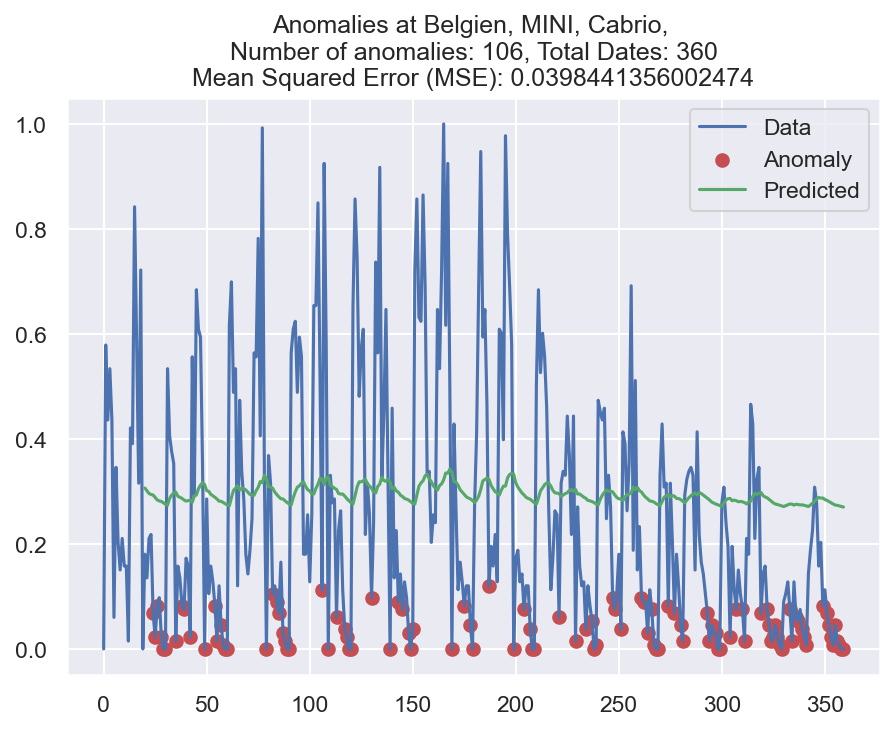

Anomalies: 106
Dates: 360
Categorized Anomalies:
Anomaly at index 30 on date 2004-02-01 00:00:00: Low Magnitude + No Change + Seasonal Dip
Anomaly at index 60 on date 2004-03-01 00:00:00: Low Magnitude + No Change + Seasonal Peak
Anomaly at index 90 on date 2004-04-01 00:00:00: Low Magnitude + No Change
Anomaly at index 120 on date 2004-05-01 00:00:00: Low Magnitude + No Change
Anomaly at index 150 on date 2004-06-01 00:00:00: Low Magnitude + Increasing Trend + Seasonal Peak
Anomaly at index 333 on date 2007-12-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Peak + Persistent Low
Anomaly at index 29 on date 2008-01-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Dip
Anomaly at index 59 on date 2008-02-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Dip
Anomaly at index 89 on date 2008-03-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Peak
Anomaly at index 119 on date 2008-04-01 00:00:00: Low Magnitude + Decreasing Trend
Anomaly at index 149 on date 

In [13]:
detect_anomalies('Belgien', 'MINI', 'Cabrio', '', lookback=20, threshold=0.2)

Shape of X_train: (51, 20, 1)
Shape of y_train: (51, 1)
Shape of X_test: (13, 20, 1)
Shape of y_test: (13, 1)
Epoch 1/20
2/2 [==============================] - 0s 53ms/step - loss: 0.2865 - accuracy: 0.3137
Epoch 2/20
2/2 [==============================] - 0s 54ms/step - loss: 0.2705 - accuracy: 0.3137
Epoch 3/20
2/2 [==============================] - 0s 58ms/step - loss: 0.2576 - accuracy: 0.3137
Epoch 4/20
2/2 [==============================] - 0s 56ms/step - loss: 0.2474 - accuracy: 0.3137
Epoch 5/20
2/2 [==============================] - 0s 60ms/step - loss: 0.2398 - accuracy: 0.3137
Epoch 6/20
2/2 [==============================] - 0s 62ms/step - loss: 0.2394 - accuracy: 0.3137
Epoch 7/20
2/2 [==============================] - 0s 52ms/step - loss: 0.2314 - accuracy: 0.3137
Epoch 8/20
2/2 [==============================] - 0s 46ms/step - loss: 0.2265 - accuracy: 0.3137
Epoch 9/20
2/2 [==============================] - 0s 44ms/step - loss: 0.2225 - accuracy: 0.3137
Epoch 10/20
2/2 [

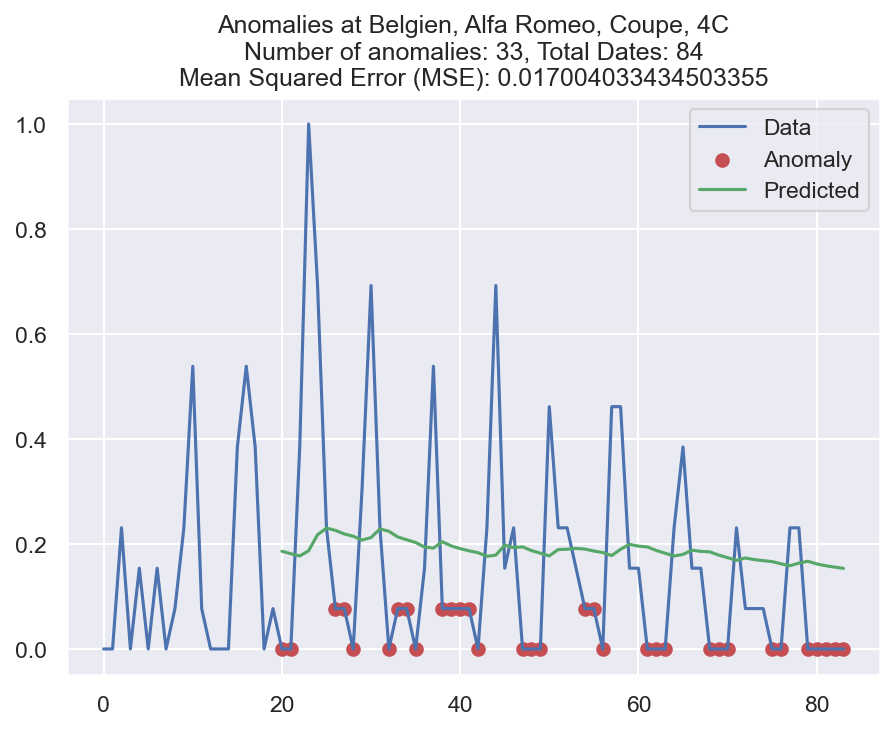

Anomalies: 33
Dates: 84
Categorized Anomalies:
Anomaly at index 21 on date 2013-04-01 00:00:00: Low Magnitude + No Change
Anomaly at index 28 on date 2013-05-01 00:00:00: Low Magnitude + Decreasing Trend
Anomaly at index 35 on date 2013-06-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Peak
Anomaly at index 42 on date 2013-07-01 00:00:00: Low Magnitude + Decreasing Trend
Anomaly at index 49 on date 2013-08-01 00:00:00: Low Magnitude + No Change + Seasonal Dip
Anomaly at index 56 on date 2013-09-01 00:00:00: Low Magnitude + Decreasing Trend
Anomaly at index 63 on date 2013-10-01 00:00:00: Low Magnitude + No Change
Anomaly at index 70 on date 2013-11-01 00:00:00: Low Magnitude + No Change
Anomaly at index 79 on date 2015-12-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Peak + Drop + Persistent Low
Anomaly at index 38 on date 2016-06-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Peak + Drop + Persistent Low
Anomaly at index 80 on date 2016-12-01 00:00:00: L

In [14]:
detect_anomalies('Belgien', 'Alfa Romeo', 'Coupe', '4C', lookback=20, threshold=0.1)

Shape of X_train: (11, 10, 1)
Shape of y_train: (11, 1)
Shape of X_test: (3, 10, 1)
Shape of y_test: (3, 1)
Epoch 1/20
1/1 [==============================] - 0s 51ms/step - loss: 0.3126 - accuracy: 0.3636
Epoch 2/20
1/1 [==============================] - 0s 37ms/step - loss: 0.2989 - accuracy: 0.3636
Epoch 3/20
1/1 [==============================] - 0s 37ms/step - loss: 0.2875 - accuracy: 0.3636
Epoch 4/20
1/1 [==============================] - 0s 36ms/step - loss: 0.2804 - accuracy: 0.3636
Epoch 5/20
1/1 [==============================] - 0s 35ms/step - loss: 0.2797 - accuracy: 0.3636
Epoch 6/20
1/1 [==============================] - 0s 34ms/step - loss: 0.2697 - accuracy: 0.3636
Epoch 7/20
1/1 [==============================] - 0s 33ms/step - loss: 0.2668 - accuracy: 0.3636
Epoch 8/20
1/1 [==============================] - 0s 34ms/step - loss: 0.2587 - accuracy: 0.3636
Epoch 9/20
1/1 [==============================] - 0s 32ms/step - loss: 0.2545 - accuracy: 0.3636
Epoch 10/20
1/1 [==

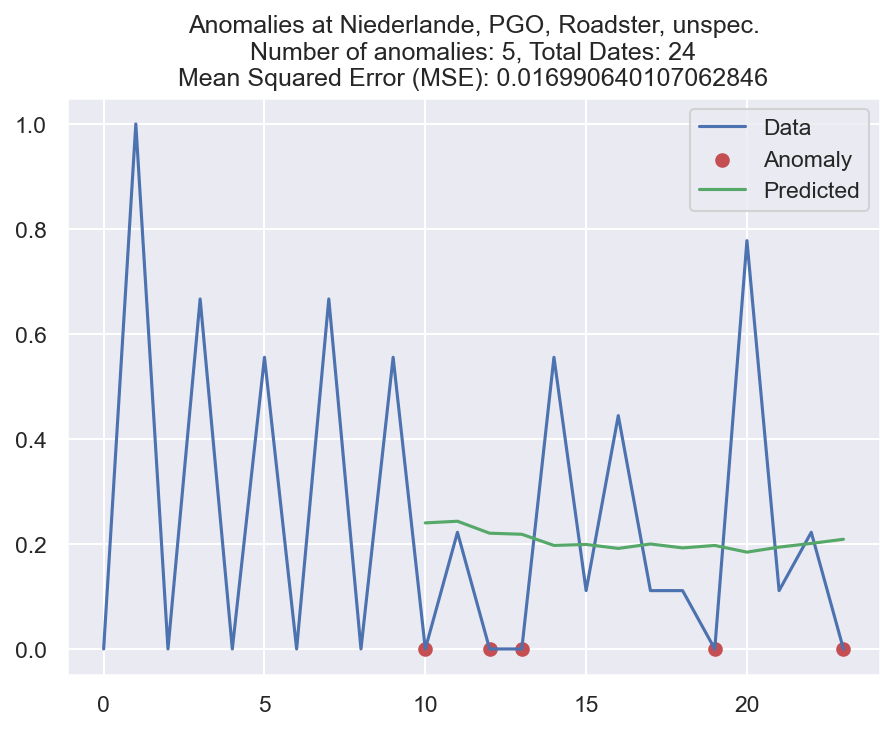

Anomalies: 5
Dates: 24
Categorized Anomalies:
Anomaly at index 10 on date 2004-06-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Peak + Drop
Anomaly at index 12 on date 2004-07-01 00:00:00: Low Magnitude + Decreasing Trend + Drop
Anomaly at index 13 on date 2005-07-01 00:00:00: Low Magnitude + No Change
Anomaly at index 19 on date 2005-10-01 00:00:00: Low Magnitude + Decreasing Trend
Anomaly at index 23 on date 2005-12-01 00:00:00: Low Magnitude + Decreasing Trend + Seasonal Peak + Drop + Persistent Low


In [15]:
detect_anomalies('Niederlande', 'PGO', 'Roadster', 'unspec.', lookback=10, threshold=0.1)

Shape of X_train: (358, 20, 1)
Shape of y_train: (358, 1)
Shape of X_test: (90, 20, 1)
Shape of y_test: (90, 1)
Epoch 1/20
12/12 [==============================] - 1s 44ms/step - loss: 0.2449 - accuracy: 0.2291
Epoch 2/20
12/12 [==============================] - 1s 43ms/step - loss: 0.2036 - accuracy: 0.2291
Epoch 3/20
12/12 [==============================] - 1s 44ms/step - loss: 0.1721 - accuracy: 0.2291
Epoch 4/20
12/12 [==============================] - 1s 43ms/step - loss: 0.1448 - accuracy: 0.2291
Epoch 5/20
12/12 [==============================] - 1s 42ms/step - loss: 0.1198 - accuracy: 0.2291
Epoch 6/20
12/12 [==============================] - 1s 43ms/step - loss: 0.0980 - accuracy: 0.2291
Epoch 7/20
12/12 [==============================] - 1s 46ms/step - loss: 0.0798 - accuracy: 0.2291
Epoch 8/20
12/12 [==============================] - 1s 51ms/step - loss: 0.0641 - accuracy: 0.2291
Epoch 9/20
12/12 [==============================] - 1s 46ms/step - loss: 0.0507 - accuracy: 0.22

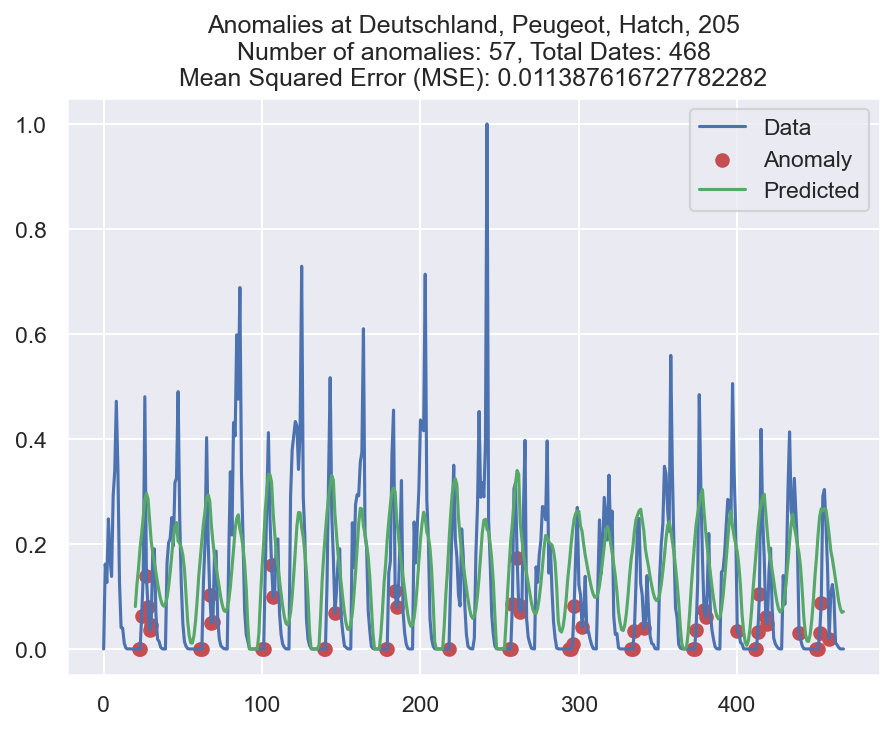

Anomalies: 57
Dates: 468
Categorized Anomalies:
Anomaly at index 23 on date 1983-01-01 00:00:00: Low Magnitude + No Change + Seasonal Dip
Anomaly at index 62 on date 1983-02-01 00:00:00: Low Magnitude + No Change + Seasonal Dip
Anomaly at index 101 on date 1983-03-01 00:00:00: Low Magnitude + No Change + Seasonal Peak
Anomaly at index 140 on date 1983-04-01 00:00:00: Low Magnitude + No Change
Anomaly at index 179 on date 1983-05-01 00:00:00: Low Magnitude + No Change
Anomaly at index 218 on date 1983-06-01 00:00:00: Low Magnitude + No Change + Seasonal Peak
Anomaly at index 257 on date 1983-07-01 00:00:00: Low Magnitude + Increasing Trend
Anomaly at index 296 on date 1983-08-01 00:00:00: Low Magnitude + Increasing Trend + Seasonal Dip
Anomaly at index 335 on date 1983-09-01 00:00:00: Low Magnitude + Increasing Trend
Anomaly at index 374 on date 1983-10-01 00:00:00: Low Magnitude + Increasing Trend
Anomaly at index 413 on date 1983-11-01 00:00:00: Low Magnitude + Increasing Trend
Anomal

In [16]:
detect_anomalies('Deutschland', 'Peugeot', 'Hatch', '205', lookback=20, threshold=0.15)